# Fine-Tuning GPT2 on Reddit Data using Huggingface Transformers

By Oliver Posewitz


### The Goal

In this notebook we are importing a pretrained language model, GPT-2, developed by OpenAI and fine-tune this model based on Reddit posts and comments within the subreddit AITA (Am I The A\**hole). The goal of this notebook is to fine tune a language model that can accurately generate text  that is similar to posts and responses told in this community. The resulting model could either generate new posts given a prompt, or generate text similar to a comment given a post as a prompt.


### The Data

The data has two sources. The first source comes from username 'elleobrien' posted on [Github](https://github.com/iterative/aita_dataset). This dataset includes ~97k rows containing post ID, post title, post body, and other information. 

The second data source came directly from Reddit using a script I created with the PRAW (Python Reddit API Wrapper) package to collect the top three comments for each post. More on that later.


### The Model

GPT-2 or Generative Pre-trained Transformer 2 is a "large-scale unsupervised language model which generates coherent paragraphs of text, achieves state-of-the-art performance on many language modeling benchmarks, and performs rudimentary reading comprehension, machine translation, question answering, and summarization..." (openai.com, 2019) The model was trained to predict the next token in a sequence given the previous tokens. This is one of the defining characteristics of a causal language model, since it makes predictions based on previous tokens, this makes the model inherently unidirectional as compared to bi-directional models (like BERT) that predict masked tokens based on the surrounding tokens.


### The How 


This notebook uses the Huggingface Transformers API's to load in the pretrained model, fine-tune the model, save the model, and generate text. The GPT-2 model will be fine-tuned on the text from the data where the label data is simply the original text shifted to the right. Since GPT2 is a causal model, it encodes in one direction as compared to a bi-directional BERT model. This means it will predict the next token based on the previous tokens in the text. One thing to note is that each sample we are feeding to the model will be a post/comment pair. The tokenizer for the GPT-2 model contains special tokens for end of sequence, padding, etc. but no special token for 'between the post and the comment'. Inserting the special token <|response|> is an arbitrary token that was selected as it is not likely to be previously contained in the tokenizer vocabulary. This new token is used to help define a pattern where a model can predict the response (in this case a comment) after prompted with a post. Hopefully, the model will learn to respond in a similar fashion to the comments in the training data. 

### Key Terms

AITA:

 - Am I the A\**hole, a subreddit hosted on social media platform Reddit where users post a story where the righteousness of a particular person in the story is in question, and other users respond to the poster's story giving their opinion on whether or not the person in question in an A\**hole.

Causal Language Model (CLM):

- A language model that makes predictions of the next token in a sequence based on the previous tokens.   



# Set up Packages

In [1]:
!pip install transformers # facilitates loading in pre-trained models
!pip install datasets     # generative data loading framework

     |████████████████████████████████| 3.4 MB 4.2 MB/s 
     |████████████████████████████████| 596 kB 32.9 MB/s 
     |████████████████████████████████| 895 kB 63.2 MB/s 
     |████████████████████████████████| 3.3 MB 52.3 MB/s 
     |████████████████████████████████| 61 kB 466 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 298 kB 3.9 MB/s 
     |████████████████████████████████| 243 kB 40.4 MB/s 
     |████████████████████████████████| 1.1 MB 31.3 MB/s 
     |████████████████████████████████| 132 kB 46.1 MB/s 
     |████████████████████████████████| 271 kB 43.8 MB/s 
     |████████████████████████████████| 192 kB 45.2 MB/s 
     |████████████████████████████████| 160 kB 46.1 MB/s 


In [2]:
import pandas as pd
import numpy as np
import re
import os
import tensorflow as tf
from tensorflow import keras
import requests
import io

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocess Data

There's a sharable link [here](https://drive.google.com/file/d/1ebB4Qzj_v8nGJ7r-hvCzfcmmFfaZrbXr/view?usp=sharing) where the csv file is publicly available.

In [4]:
# Here's a link to the dataset
csv_link = 'https://drive.google.com/file/d/1ebB4Qzj_v8nGJ7r-hvCzfcmmFfaZrbXr/view?usp=sharing'

csv_location = '/content/drive/MyDrive/NLP/project/posts_and_comments.csv'
# read in posts and comments file
posts = pd.read_csv(csv_location)


,Unnamed: 0,id,timestamp,title,body,edited,verdict,score,num_comments,is_asshole,comment_all,comment1,comment2,comment3
0,0,1ytxov,1.393279e+09,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,False,asshole,52,13.0,1,['There is nothing wrong with your original co...,There is nothing wrong with your original comm...,I'm pretty sure the guy you responded to was j...,"Dude, you're introspective when someone is try..."
1,1,1yu29c,1.393281e+09,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",1393290576.0,asshole,140,27.0,1,['Yep. You\'re the asshole. If you want to m...,Yep. You're the asshole. If you want to make...,There are better ways to resolve this kind of ...,"Sort of yes, and sort of no.\n\nYou were looki..."
2,2,1yu8hi,1.393285e+09,I told a goth girl she looked like a clown.,I was four.,False,not the asshole,74,15.0,0,"[""Kids say ridiculous things all the time, and...","Kids say ridiculous things all the time, and i...",You were four.,"What an- oh, little kid. *laughs*"
3,3,1yuc78,1.393287e+09,[AItA]: Argument I had with another redditor i...,http://www.reddit.com/r/HIMYM/comments/1vvfkq/...,1393286962.0,everyone sucks,22,3.0,1,"[""I'm not reading that. But don't stay in a fl...",I'm not reading that. But don't stay in a flam...,"You're an asshole, but only for arguing with a...",spacecowboy007 is like the reason for this sub...
4,4,1yueqb,1.393288e+09,[AITA] I let my story get a little long and bo...,NaN,False,not the asshole,6,4.0,0,"[""A real yawn? Or an I'm-trying-to-draw-atten...",A real yawn? Or an I'm-trying-to-draw-attenti...,They probably were not intentionally yawning t...,NAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97615,97615,ex94w5,1.580577e+09,AITA for telling my sister she is being a spoi...,My sister(17F) and I(15M) are white kids born ...,1580585457.0,not the asshole,16,23.0,0,"[""\nIf you want your comment to count toward j...",\nIf you want your comment to count toward jud...,INFO What exactly did she say about the homele...,"NTA\n\nYou told your sister the truth, she’s g..."
97616,97616,ex970f,1.580577e+09,AITA for telling my husband to f* off after he...,My husband (28M) and I (32F) are married for a...,1580584475.0,not the asshole,1373,304.0,0,"[""\nIf you want your comment to count toward j...",\nIf you want your comment to count toward jud...,INFO.\n\nWhat the fuck is going on?,NTA I can’t even believe this is real it’s so ...
97617,97617,ex9dwo,1.580578e+09,AITA for attempting to keep my students out of...,Upfront apologies for formatting. I’m also try...,False,not the asshole,4,15.0,0,"[""\nIf you want your comment to count toward j...",\nIf you want your comment to count toward jud...,Nta\n\nIf these people are speaking to student...,ESH but the kids\n\nI think the owner sucks fo...
97618,97618,ex9egs,1.580578e+09,WIBTA if I left my brothers fate up to the state?,A little back story my mom is a drug addict an...,False,not the asshole,280,140.0,0,"[""\nIf you want your comment to count toward j...",\nIf you want your comment to count toward jud...,He's 2.\n\nI doubt genetics will play more of ...,NTA. I think you should think this over carefu...


In [5]:
# Combine the title and body as one string of text
posts.body = posts.body.fillna(value=' ')
posts['title_body'] = posts.title +' '+ posts.body

## Elongate the Data

Here we have a unique column of posts along with three other columns that contain the top three comments for each post. We want to convert this format into one column for the post text and one column for the comment text. This will result in duplicate values for the title_body text which is okay. This way we can treat each row as a single sample to feed into the model later on.

In [6]:
post_comment1 = posts[['id','title_body','comment1']].rename(columns={'comment1':'comment'})
post_comment2 = posts[['id','title_body','comment2']].rename(columns={'comment2':'comment'})
post_comment3 = posts[['id','title_body','comment3']].rename(columns={'comment3':'comment'})

posts_long = pd.concat([post_comment1,post_comment2,post_comment3])
posts_long = posts_long.dropna()
posts_long

,id,title_body,comment
0,1ytxov,[AITA] I wrote an explanation in TIL and came ...,There is nothing wrong with your original comm...
1,1yu29c,[AITA] Threw my parent's donuts away My parent...,Yep. You're the asshole. If you want to make...
2,1yu8hi,I told a goth girl she looked like a clown. I ...,"Kids say ridiculous things all the time, and i..."
3,1yuc78,[AItA]: Argument I had with another redditor i...,I'm not reading that. But don't stay in a flam...
4,1yueqb,[AITA] I let my story get a little long and bo...,A real yawn? Or an I'm-trying-to-draw-attenti...
...,...,...,...
97615,ex94w5,AITA for telling my sister she is being a spoi...,"NTA\n\nYou told your sister the truth, she’s g..."
97616,ex970f,AITA for telling my husband to f* off after he...,NTA I can’t even believe this is real it’s so ...
97617,ex9dwo,AITA for attempting to keep my students out of...,ESH but the kids\n\nI think the owner sucks fo...
97618,ex9egs,WIBTA if I left my brothers fate up to the sta...,NTA. I think you should think this over carefu...


## Clean Text

Removing things like url addresses and bot messages would help by reducing noise in our dataset. This would help our model in learning more relevant responses and avoid teaching it to respond with garbled up url addresses or echo messages from Reddit bots that tend to be a good portion of the comment section.

In [7]:
# remove URLs
posts_long.title_body = posts_long.title_body.str.replace(r'\(http\S+', ' ', regex=True)
posts_long.comment = posts_long.comment.str.replace(r'\(http\S+', ' ', regex=True)

# remove newlines to avoid escape errors
posts_long.title_body = posts_long.title_body.str.replace('\n', ' ')
posts_long.comment = posts_long.comment.str.replace('\n', ' ')

### Filtering out the Junk

Reddit is very proactive when it comes to moderating it's content and enforcing community rules using automated bots. This results in many of the comments either being deleted, or comments authored by the bots themselves may respond to the original poster for different reasons. These messages tend to be repetative and could cause our model to simply repeat what a bot says. We ensure the text is clean by grouping the dataframe by comment then sorting by group size. The largest groups would show us if there's repetative values that we should filter out. The same is done for the posts, but they are mostly clean to begin with.

Notice the difference in lengths between the dataframes before the filtering then after. About 100k of our comments were junk! 

In [8]:
# Filter out rows where comment is a (reddit) bot
posts_long = posts_long[~posts_long['comment'].str.contains('I am a bot')]

# filter out deleted comments
posts_long = posts_long[~posts_long['comment'].str.contains('\[deleted\]', regex=True)]

# filter out removed comments
posts_long = posts_long[~posts_long['comment'].str.contains('\[removed\]', regex=True)]
posts_long = posts_long[~posts_long['comment'].str.contains('I delete my old comments for a reason my friend', regex=True)]

# filter out overwritten comments
posts_long = posts_long[~posts_long['comment'].str.contains('This comment has been overwritten by an open source script to protect this user')]

# filter out automod responses
posts_long = posts_long[~posts_long['comment'].str.contains('If you want your comment to count toward judgement', regex=True)]
posts_long = posts_long[~posts_long['comment'].str.contains('Banned for criticizing mods', regex=True)]
posts_long = posts_long[~posts_long['comment'].str.contains('#\[Be Civil\]', regex=True)]
posts_long = posts_long[~posts_long['comment'].str.contains('Please remember this is not a debate sub.', regex=True)]


print(len(posts_long))

# check the top 5 occurances for title_body and comment to ensure text is clean

#grouped = posts_long.groupby(by='comment')
#grouped.size().sort_values(ascending=False)[:5]

194191


## Adding Special Tokens into Text

Pretrained models often have different naming conventions for special tokens that are used in the training process that perform specific functions. In this case, the GPT-2 model already contains special tokens to specify the beginning and end of a sequence of text. I am adding my own special token between the post text and comment text to help the model learn the difference between the post and the comment instead of treating the sequence as one string of text. 
The idea of 

In [9]:
# Prepend each post and comment with special prompt token

posts_long.comment = ' <|response|> '+posts_long.comment + ' <|endoftext|> '

The distilGPT2 model has a maximum sequence length of 1024. By quickly reducing the post and comments to 500 and 512 sequences, this ensures each sample fed into the model will not exceed the maximum. Further truncation will likely be needed after the tokenization proccess, however, quickly reducing some of the larger samples before this step could reduce computational overhead.

In [10]:
# limit the post text to 512 words then concatenate post and comment

post_text = posts_long.title_body.values.tolist()
comm_text = posts_long.comment.values.tolist()

# truncate title_body for a max of 512
post_text = [' '.join(i.split()[:512]) for i in post_text]
comm_text = [' '.join(i.split()[:512]) for i in comm_text]

cleaned_df = pd.DataFrame({'title_body' : post_text,
                           'comment' : comm_text})
cleaned_df

,title_body,comment
0,[AITA] I wrote an explanation in TIL and came ...,<|response|> There is nothing wrong with your ...
1,[AITA] Threw my parent's donuts away My parent...,<|response|> Yep. You're the asshole. If you w...
2,I told a goth girl she looked like a clown. I ...,<|response|> Kids say ridiculous things all th...
3,[AItA]: Argument I had with another redditor i...,<|response|> I'm not reading that. But don't s...
4,[AITA] I let my story get a little long and bo...,<|response|> A real yawn? Or an I'm-trying-to-...
...,...,...
194186,AITA for telling my sister she is being a spoi...,<|response|> NTA You told your sister the trut...
194187,AITA for telling my husband to f* off after he...,<|response|> NTA I can’t even believe this is ...
194188,AITA for attempting to keep my students out of...,<|response|> ESH but the kids I think the owne...
194189,WIBTA if I left my brothers fate up to the sta...,<|response|> NTA. I think you should think thi...


In [11]:
# concatenate title_body and comment into one string
cleaned_df_combined = cleaned_df.title_body + ' ' + cleaned_df.comment

# reshape Series to Dataframe for loading into datasets
cleaned_df_combined = pd.DataFrame({'text':cleaned_df_combined})

print(type(cleaned_df))
cleaned_df_samp = cleaned_df_combined.sample(frac=.25, random_state=1)

<class 'pandas.core.frame.DataFrame'>


In [12]:
cleaned_df

,title_body,comment
0,[AITA] I wrote an explanation in TIL and came ...,<|response|> There is nothing wrong with your ...
1,[AITA] Threw my parent's donuts away My parent...,<|response|> Yep. You're the asshole. If you w...
2,I told a goth girl she looked like a clown. I ...,<|response|> Kids say ridiculous things all th...
3,[AItA]: Argument I had with another redditor i...,<|response|> I'm not reading that. But don't s...
4,[AITA] I let my story get a little long and bo...,<|response|> A real yawn? Or an I'm-trying-to-...
...,...,...
194186,AITA for telling my sister she is being a spoi...,<|response|> NTA You told your sister the trut...
194187,AITA for telling my husband to f* off after he...,<|response|> NTA I can’t even believe this is ...
194188,AITA for attempting to keep my students out of...,<|response|> ESH but the kids I think the owne...
194189,WIBTA if I left my brothers fate up to the sta...,<|response|> NTA. I think you should think thi...


# Load in Tokenizer

The following blocks of code code is a modification of Huggingface Transformers example script posted [here](https://github.com/huggingface/transformers/blob/master/examples/tensorflow/language-modeling/run_clm.py). 

In [13]:
import transformers
import datasets
from datasets import Dataset

### I thought we were using GPT2, what's this distilpgt2?

 - distilgpt2 is a much smaller version of the GPT2 model.

In order to successfully train all the parameters of a model, we need to load in all the weights associated with each node in each layer. The original GPT2 model  has about 1.5 billion parameters. There other versions that are smaller than the original, but even the smallest version contains 124 million parameters. distilGPT2 is a further reduced version of the original that was created by user 'patrickvonplaten' and made easily found through Hugging Face where the repository is made available through git. The model card and repository can be found [here](https://huggingface.co/distilgpt2)

In [14]:
from transformers import AutoTokenizer

model_name = 'distilgpt2'

# load in the tokenizer that's configured for gpt2
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Here is where we add those special tokens as mentioned before. 

In [15]:
# view the special tokens mapping
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>'}

Using the datasets package, we can convert our Pandas DataFrame object into a datasets object. The main advantage of using datasets for handling our data is that it has generative processing built in. Meaning it serves the data in batches so we're less likely to run into memory errors while we prepared the data for our model.

In [16]:
# Load data into generative framework
text_dataset = Dataset.from_pandas(cleaned_df_samp)
text_dataset = text_dataset.train_test_split()
text_dataset

DatasetDict({
    train: Dataset({
        features: ['text', '__index_level_0__'],
        num_rows: 36411
    })
    test: Dataset({
        features: ['text', '__index_level_0__'],
        num_rows: 12137
    })
})

In [17]:
def tokenize_function(text_input):
    return tokenizer(text_input['text'])

The mapping function is used to tokenize the text with the tokenizer we loaded in. 

In [18]:
# tokenize the text
tokenized_datasets = text_dataset.map(
    tokenize_function, 
    batched=True, 
    remove_columns=['text', '__index_level_0__']
) 

  0%|          | 0/37 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1114 > 1024). Running this sequence through the model will result in indexing errors


  0%|          | 0/13 [00:00<?, ?ba/s]

In [19]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids'],
        num_rows: 36411
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids'],
        num_rows: 12137
    })
})

## Group the text into smaller blocks

Since gpu memory is very limited, in addition to feeding samples to our model in batches, we first reduce the size of sequences to be at most the maximum length the model is able to input, which for gpt2 it's 1024 inputs. 

Since This would likely result in Out of Memory Errors using Google Colab, we elect to feed the model in shorter sequences to reduce the GPU memory overhead. This function concatenates all the text as one long token sequence, clipping off the tokens at the very end that weren't enough to make a full sized block.

Note how the 'labels' dictionary key in the data set is merely a copy of the 'input_ids'. That's because for each sequence of tokens fed into the model, it uses the tokens themselves as the prediction label. For the GPT2 model, shifting the label tokens to the right is done internally, so no need for that.

Again, this function was copied and modified from the Transformers example script they posted on Github.

In [20]:
# group text into smaller block sizes

# source: https://github.com/huggingface/transformers/blob/master/examples/tensorflow/language-modeling/run_clm.py

block_size = 240

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    
    # Drop the small remainder
    total_length = (total_length // block_size) * block_size

    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result
    

In [21]:
lm_datasets = tokenized_datasets.map(
    group_texts,
    batched=True   
)

  0%|          | 0/37 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

Notice how the number of rows has increased. This is due to the fact that each row is only a fraction of a full sequence, thanks to our group_texts function.

In [22]:
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 70375
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 23532
    })
})

In [23]:
# check one decoded sample
print(tokenizer.decode(lm_datasets["train"][1]["input_ids"]))

 from her high school on one of his vlogs. I'm not terribly interested in Youtubers, but I am always happy to talk about things that she's interested in, so I told her that I thought that was great and was asking her questions about it. She replied with, "I have a question... would you be upset if I flashed my boobs to get on one of his vlogs?" I paused because I had no idea how to answer the question, then I replied with "It would make me really uncomfortable". &#x200B; This follows a trend of hers where it seems like she's challenging my boundaries. It will range from innocent questions such as "Would you be okay if I had to kiss some one for a play?" to vulgar questions like "Would you be okay if I sucked someone's dick for X amount of money?" or "How would you react if you caught me making out with someone?". We have an immature sense of humor, so I figured these things were crass jokes. When she clarified it was serious I gave her honest answers. While I was quiet at first about t

## Collate Text

Now that we have our blocks of text, we need to convert these object into tensors that Tensorflow can understand. The Data Collator lets us convert our dict-like objects stored in the datasets object and turn it into a collated sequence of text. We also designate return_tensors='tf', which returns Tensorflow tensors. 

In [24]:
from transformers import DefaultDataCollator

# convert the datasets into tensors that tensorflow can interpret
# source: https://github.com/huggingface/transformers/blob/master/examples/tensorflow/language-modeling/run_clm.py

data_collator = DefaultDataCollator(return_tensors='tf')

train_set = lm_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=2,
    collate_fn=data_collator
)
validation_set = lm_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=2,
    collate_fn=data_collator
)

In [25]:
train_set

<PrefetchDataset shapes: {input_ids: (2, None), labels: (2, None), attention_mask: (2, None)}, types: {input_ids: tf.int64, labels: tf.int64, attention_mask: tf.int64}>

# Load In  Pre-trained Model

We are using a causal language model as they use the previous sequences for prediction of future sequences. Compared to the Masked language modeling, where predictions are base on surrounding text on either side of a masked token. 

In [26]:
from transformers import TFAutoModelForCausalLM
from transformers import create_optimizer, AdamWeightDecay

# load in distilgpt2 model 
model = TFAutoModelForCausalLM.from_pretrained(model_name)
optimizer = AdamWeightDecay()
model.compile(optimizer=optimizer)
    

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! Please ensure your labels are passed as the 'labels' key of the input dict so that they are accessible to the model during the forward pass. To disable this behaviour, please pass a loss argument, or explicitly pass loss=None if you do not want your model to compute a loss.


This helper class was copied from the same [example script](https://github.com/huggingface/transformers/blob/master/examples/tensorflow/language-modeling/run_clm.py) previously mentioned. It's useful for when you want to save your progress in between training epochs so if the script stops running, you can pick up where you left off previously. 

# Train Model

Set the train batch size as high as possible without causing out of memory errors to improve performance. Increasing epochs can help improve model performance up to a certain extent.

In [27]:
model_save_folder = '/content/drive/MyDrive/NLP/project/distilgpt2-finetuned-reddit'
model_file = os.listdir(model_save_folder)

# train only if there is no model saved in folder
if len(os.listdir(model_save_folder)) == 0:
  
  train_batch_size = 24
  
  # fit model 
  history = model.fit(
      train_set,
      validation_data=validation_set, 
      epochs=3,
      steps_per_epoch = len(train_set) // train_batch_size
      )
  model.save_pretrained(model_save_folder)
  # in order to push your model, you need to sign up with hugginface.co
  # then you will be able to insert your own token into the command below
  model.push_to_hub('oliverP/distilgpt2-finetuned-reddit', use_auth_token= '')
  tokenizer.push_to_hub('oliverP/distilgpt2-finetuned-reddit', use_auth_token= '')
  
  


For training, I actually used my personal computer as it was faster than the free instance offered in Google Colab. For faster training times, you can reduce the sample size of the original data, reduce block size for less memory overhead, and reduce batch size. It depends on the resources you have at your disposal.

## Upload model to model hub

# Load Tuned Model

Once we have done some fine-tuning on the pretrained model, we save it to a file and load in the tuned model and observe how it performs.

In [28]:
import transformers
from transformers import TFAutoModelForCausalLM, AutoTokenizer

path2model = 'oliverP/distilgpt2-finetuned-reddit'

tuned_model = TFAutoModelForCausalLM.from_pretrained(path2model)
tuned_tokenizer = AutoTokenizer.from_pretrained(path2model)

Downloading:   0%|          | 0.00/982 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at oliverP/distilgpt2-finetuned-reddit.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Downloading:   0%|          | 0.00/242 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

# Observe Model Outputs

## Generate Text with our Model

Using the input_context as our text input, we encode our text with our loaded tokenizer, then generate text with the generator method using the input encodings with parameters that I found to be the most useful.

The output tensor also includes the input text, so I sliced the input out of the response for ease of interpretation.

In [29]:
def generate_response(input_context):
  # encode input context
  input_ids = tuned_tokenizer.encode(input_context, return_tensors='tf')  
  input_len = input_ids.shape[1]

  output_len = input_len + 300

  if output_len >= 1024:
    output_len = 1024

  outputs = tuned_model.generate(input_ids = input_ids,
                           max_length = output_len, 
                           temperature = 0.7, 
                           num_return_sequences = 1,
                           repetition_penalty = 1.5, 
                           do_sample = True)  # generate 3 candidates using sampling
  
  
  response = outputs[0][input_len:]
  response = tuned_tokenizer.decode(response, skip_special_tokens=True)
  
  return response

Here we randomly select a post that was written by a user on Reddit. We also take the corresponding comments for comparison.

In [30]:
# Randomly select a post and get the associated comments
def get_rand_post():

    rand_post = cleaned_df.sample(1).title_body.values[0]

    post_comments = cleaned_df[cleaned_df['title_body']==rand_post]['comment'].values
    
    return rand_post, post_comments

# Demontration

This simple function interacts with the user of the code so that they can enter in their own text to get a generated response using the input text as context. 

There is also an option that allows the user to use a previous post within the dataset, and compare the Reddit comments with the model generated comments.

In [31]:
import textwrap

# Takes user input to generate a response, or uses a previous post as a prompt
usr_inp = f'''
Enter your own story here to generate a comment-like response, 
To have the model create its own story, prompt the model beginning with AITA,
to generate a previous post press enter, 
to quit type quit
'''

while True:
  user_input = input(usr_inp)

  if user_input == 'quit':
    print('goodbye')
    break

  #  Generate comment-like response using existing post
  if user_input == '':
    rand_post, post_comments = get_rand_post()
    print('Using random post:\n',
          rand_post,
          '\n\nResponses From Reddit:\n',
          post_comments,
          '\nGenerating New Response...\n')
    
    response = generate_response(rand_post)
    
    print('Generated response:\n',
          response)

  # Generate post-like story
  if user_input[:4] == 'AITA':
    print('generating story...')
    response = generate_response(user_input)
    print(user_input+ ' ' + response)
  
  # Generate comment-like response using user input
  else:
    print('Generating Response with:\n', user_input)
    user_input = user_input + ' <|response|>'
    response = generate_response(user_input)
    print('Generated Response:\n', response)


Enter your own story here to generate a comment-like response, 
To have the model create its own story, prompt the model beginning with AITA,
to generate a previous post press enter, 
to quit type quit



Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Using random post:
 AITA - I Yelled at my Dad for Speaking Over Me Hello. While my dad and I were on a walk today, I was speaking to him about rolling my R’s, and Dad, wanting to help me, began speaking over me. I waited, and then spoke again. He spoke over me again. Then I yelled at him, wanting him to listen to me. My dad and I are close, but we have certain moments in our relationship where one angers the other. This was one of those moments. He told me to stop, and that I was being disrespectful. I kept going on, having been spoken over again. He feels hurt and disrespected, and I feel ignored and disrespected. I don’t need advice, just judgement on who is TA, or if we’re either both TA or NTA. I realize yelling was wrong, but interrupting was also wrong. This has been an ongoing issue and I’ve only addressed it now. AITA? EDIT: Thank you to everyone who commented on this post; I was able to see that I was being immature, and that the situation could’ve been handled better. 

Respo

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Generated response:
  Thanks again as best friends can be resolved when necessary (not been more respected.) Edit 2 days after a few months went out <|> No assholeholes and he made sure what would be understood why people did not the wholeheartedly agree with his comments are supposed others think "friend doesn't even tho 
Generating Response with:
 
Generated Response:
  NTA - The person who is a creep are right now the fuck up. You're not an asshole, but your friend doesn't have to bring it up again until you've made that clear they aren't "f*ck off." 

Enter your own story here to generate a comment-like response, 
To have the model create its own story, prompt the model beginning with AITA,
to generate a previous post press enter, 
to quit type quit
AITA if I


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


generating story...
AITA if I  don’t have a birthday dinner? Some context: My mom has 3 kids and the two of them are on a date. It was last year, but my boyfriend found out after college that they had been together for 4 years now (no idea why) we were friends since highschool in High school. We both went to different classes and then stayed with each other when we got back at 7am. He would never bring home anymore unless she didn’t want him there so he could see it herself because all his days left early. The first few months before graduation is finalized, this week he decided not to invite anyone over to celebrate Thanksgiving dinner and he will also be staying overnight even though he doesn’t care any longer than me, or even asking what time he said about my family as well. However, after having several drinks and going away all day, we had stopped hanging out. He was still quite pissed off with us being best friend-friend group on our house (in regards to these things). But yester

# Conclusion

As we have seen, OpenAI's GPT2 model performs remarkably well with text generation. The goal of this notebook was not to create a new model with pragmatic functionality, but to push the boundaries and test the generalization capabilities with massively trained transformers. Thus, GPT2 has other applications, including writing assitants, dialogue agents, unsupervised translation between languages, and more. 

### A word on Transformers

This model really captures the power of using a transformer based model and it's ability to . Transformer models use encoders and decoders in their achitecture when processing a sequence which allows the model to give more weight to tokens in a sequence based on their relation to each other rather than position in the sequence by means of the attention mechanism (see below). This type of architecture was proven to be more effective than models like Recurrent Neural Networks and Long Short-term Memory for translation tasks (Vaswani, A., et al., 2017). Relying on transformers to draw dependencies between input and output proves to be highly generalizable given the output of the model performance in this notebook.

### Moving Forward

There are many areas where this notebook can improve. 
 - more data
 - better computational resource management
 - improvements on hyperparameters

The free instance Google provides via Colab is good, but limited. While they offer GPU resources for their users, sometimes your task requires more than what this resource has to offer. 

This model was found on the [Huggingface models page](https://huggingface.co/models) where there is a hub of many other models including Google's BERT, as well as models that have been fine-tuned for a specific task like the one we made here. 

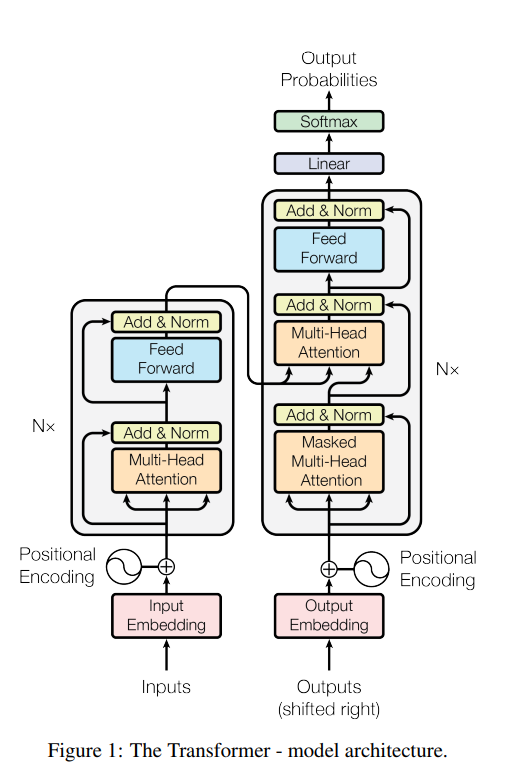

# Appenndix

1.  Radford, A., Wu, J., Child, R., Luan, D., Amodei, D., & Sutskever, I. (2019). Language models are unsupervised multitask learners. OpenAI blog, 1(8), 9.

2. Iterative. (n.d.). Iterative/AITA_DATASET: AITA dataset based on R/amitheasshole/. GitHub. Retrieved December 15, 2021, from https://github.com/iterative/aita_dataset 

3.  Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In Advances in neural information processing systems (pp. 5998-6008).

4. https://github.com/huggingface/transformers/blob/master/examples/tensorflow/language-modeling/run_clm.py
